Leer primero los archivos h5 de train y test y crear un df con pandas. Luego, separamos el df en train y test.

In [4]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.distribution import MultiprocessingDistributor
import os

with h5py.File('train.h5', 'r') as f:
    X = f['x'][:]
    Y = f['y'][:]

print(X.shape)
print(Y.shape)

# Convierte X a un DataFrame de pandas
df_X = pd.DataFrame(X.reshape(-1, X.shape[-1]))

# Convierte Y a un DataFrame de pandas
df_Y = pd.DataFrame(Y, columns=['Target'])

# Une los dos DataFrames
df = pd.concat([df_X, df_Y], axis=1)

# print(df)

num_trials = 18530

df_tsfresh = pd.DataFrame({
    'id': np.repeat(df.index, num_trials),
    'time': np.tile(np.arange(num_trials), len(df)),
    'value': df.drop(columns='Target').values.flatten()
})


#use test.h5 and predict the target and save it in a file
with h5py.File('test.h5', 'r') as f:
    XX = f['x'][:]

# Convierte X a un DataFrame de pandas
df_X_test = pd.DataFrame(XX.reshape(-1, X.shape[-1]))

df_tsfresh_test = pd.DataFrame({
    'id': np.repeat(df_X_test.index, num_trials),
    'time': np.tile(np.arange(num_trials), len(df_X_test)),
    'value': df_X_test.values.flatten()
})

(204, 1, 18530)
(204,)


Luego extraemos las features de los archivos h5 con tsfresh

In [110]:
Distributor1 = MultiprocessingDistributor(n_workers=os.cpu_count(), disable_progressbar=False, progressbar_title="Feature Extraction")
Distributor2 = MultiprocessingDistributor(n_workers=os.cpu_count(), disable_progressbar=False, progressbar_title="Feature Extraction")

features = extract_features(df_tsfresh, column_id='id', column_sort='time', distributor=Distributor1, default_fc_parameters=EfficientFCParameters())
features_test = extract_features(df_tsfresh_test, column_id='id', column_sort='time', distributor=Distributor2, default_fc_parameters=EfficientFCParameters())


Headers are the same


Después, separamos las features en train y test y las guardamos en archivos csv.

In [111]:
#save features in a file.csv
features.to_csv("features_train.csv", index=False)

#save features_test in a file.csv
features_test.to_csv("features_test.csv", index=False)

#save y in a file.csv
df_Y.to_csv("y_train.csv", index=False)

Mas adelante, cargamos las features de train de sus csv y las dividimos en train y validation.

In [15]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


# Cargar los datos
df = pd.read_csv('features_train.csv')
y = pd.read_csv('y_train.csv')
X = df
y = y['Target']


# Divide tus datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)


Despues, elegimos algun modelo de clasificación y lo entrenamos con las features de train y validamos con las features de validation.

              precision    recall  f1-score   support

           0       0.72      0.78      0.75        46
           1       0.17      0.12      0.14        16

    accuracy                           0.61        62
   macro avg       0.44      0.45      0.45        62
weighted avg       0.58      0.61      0.59        62

0.6129032258064516


c:\Users\vilch\OneDrive\Escritorio\5TH SEMESTER CODE\MACHINE LEARNING\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


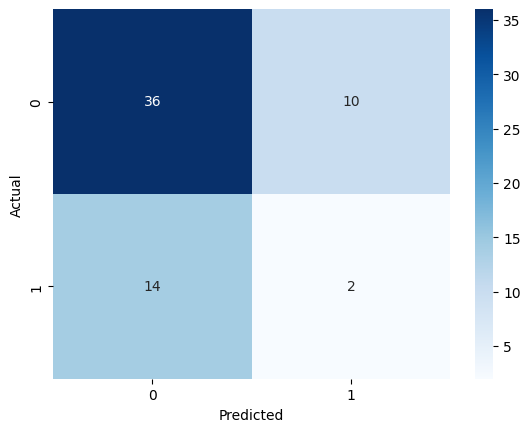

In [29]:
#import logistic regression

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=10000)

# Entrena el clasificador
clf.fit(X_train, y_train)

# Haz predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)

# Muestra el reporte de clasificación
print(classification_report(y_test, y_pred))

#get accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

#create confusion matrix
from sklearn.metrics import confusion_matrix

#plot confusion matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Finalmente predecimos las features de test y las guardamos en un archivo csv.

In [11]:
X_test = pd.read_csv('features_test.csv')
X_test = X_test.fillna(0)

# X_test = pca.transform(X_test)

# Haz predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)


#save y_pred in a file.csv with id and result. id starts from 1
df_y_pred = pd.DataFrame(y_pred, columns=['result'])
df_y_pred.index += 1
df_y_pred.index.name = 'ID'
df_y_pred.to_csv("y_pred.csv")